In [78]:
import numpy as np
import cv2 as cv
import matplotlib.ticker as ticker
from PIL import Image
from numba import njit, jit
import matplotlib.pyplot as plt
from task import noise

In [61]:
def save_noised_img(img: np.ndarray, img_name: str):
    norm_noised = noise.norm_noise_color(np.copy(img), 0, 20, .1)
    sp_noised = noise.sp_noise_color(np.copy(img), .07)
    return [norm_noised, sp_noised]

In [62]:
def gs_kernel(kernel_size: int) -> np.ndarray:
    gaus_smoothing_kernel = np.empty((kernel_size, kernel_size))
    for x in range(kernel_size):
        for y in range(kernel_size):
            gaus_smoothing_kernel = (1 / (np.pi * 2)) * np.exp(-1 * (abs(x - y) ** 2) / 2)
    return gaus_smoothing_kernel

def pad_image(img: np.ndarray, pad_size: int) -> np.ndarray:
    padding_values = ((pad_size, pad_size), (pad_size, pad_size), (0, 0))
    padded_img = np.pad(img, padding_values, mode='edge')
    return padded_img.astype('uint8')

# @njit(nogil=True)
def box_average(img: np.ndarray, kernel_size: int) -> np.ndarray:
    pading_value = int(kernel_size/2)
    pading_img = pad_img(img, pading_value)
    result_img = np.ndarray(img.shape)

    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            for k in range(img.shape[2]):
                result_img[x, y][k] = int(np.vdot(pading_img[x : x + kernel_size, y : y + kernel_size, k], 
                                                  np.ones((kernel_size, kernel_size))) / np.power(kernel_size, 2))
    return (result_img % 256).astype('uint8')

In [65]:
# @njit(nogil=True)
def median(img: np.ndarray, kernel_size: int) -> np.ndarray:
    pading_value = int(kernel_size/2)
    pading_img = pad_img(img, pading_value)

    result_img = np.ndarray(img.shape)
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            for k in range(img.shape[2]):
                if (img[x, y] == [255, 255, 255]).all() or (img[x, y] == [0, 0, 0]).all():
                    result_img[x, y][k] = np.sort(pading_img[x : x + kernel_size, y : y + kernel_size, k].reshape(np.power(kernel_size, 2)))[int(kernel_size/2)]
                else:
                    result_img[x, y][k] = img[x, y][k]

    return (result_img % 256).astype('uint8')

def wieghted_median(img: np.ndarray, kernel_size: int) -> np.ndarray:
    pading_value = int(kernel_size/2)
    pading_img = pad_img(img, pading_value)

    result_img = np.ndarray(img.shape)
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            for k in range(img.shape[2]):
                if (img[x, y] == [255, 255, 255]).all() or (img[x, y] == [0, 0, 0]).all():
                    kernel = gs_kernel(kernel_size)
                    window_kernel = np.sort(np.multiply(pading_img[x : x + kernel_size, y : y + kernel_size, k], kernel).reshape(np.power(kernel_size, 2)))
                    result_img[x, y][k] = window_kernel[int(kernel_size/2)]
                else:
                    result_img[x, y][k] = img[x, y][k]

    return (result_img % 255).astype('uint8')

In [73]:
minion = cv.imread("source/minion.jpg")
dota = cv.imread("source/dota2.jpg")
cat = cv.imread("source/cat.jpg")

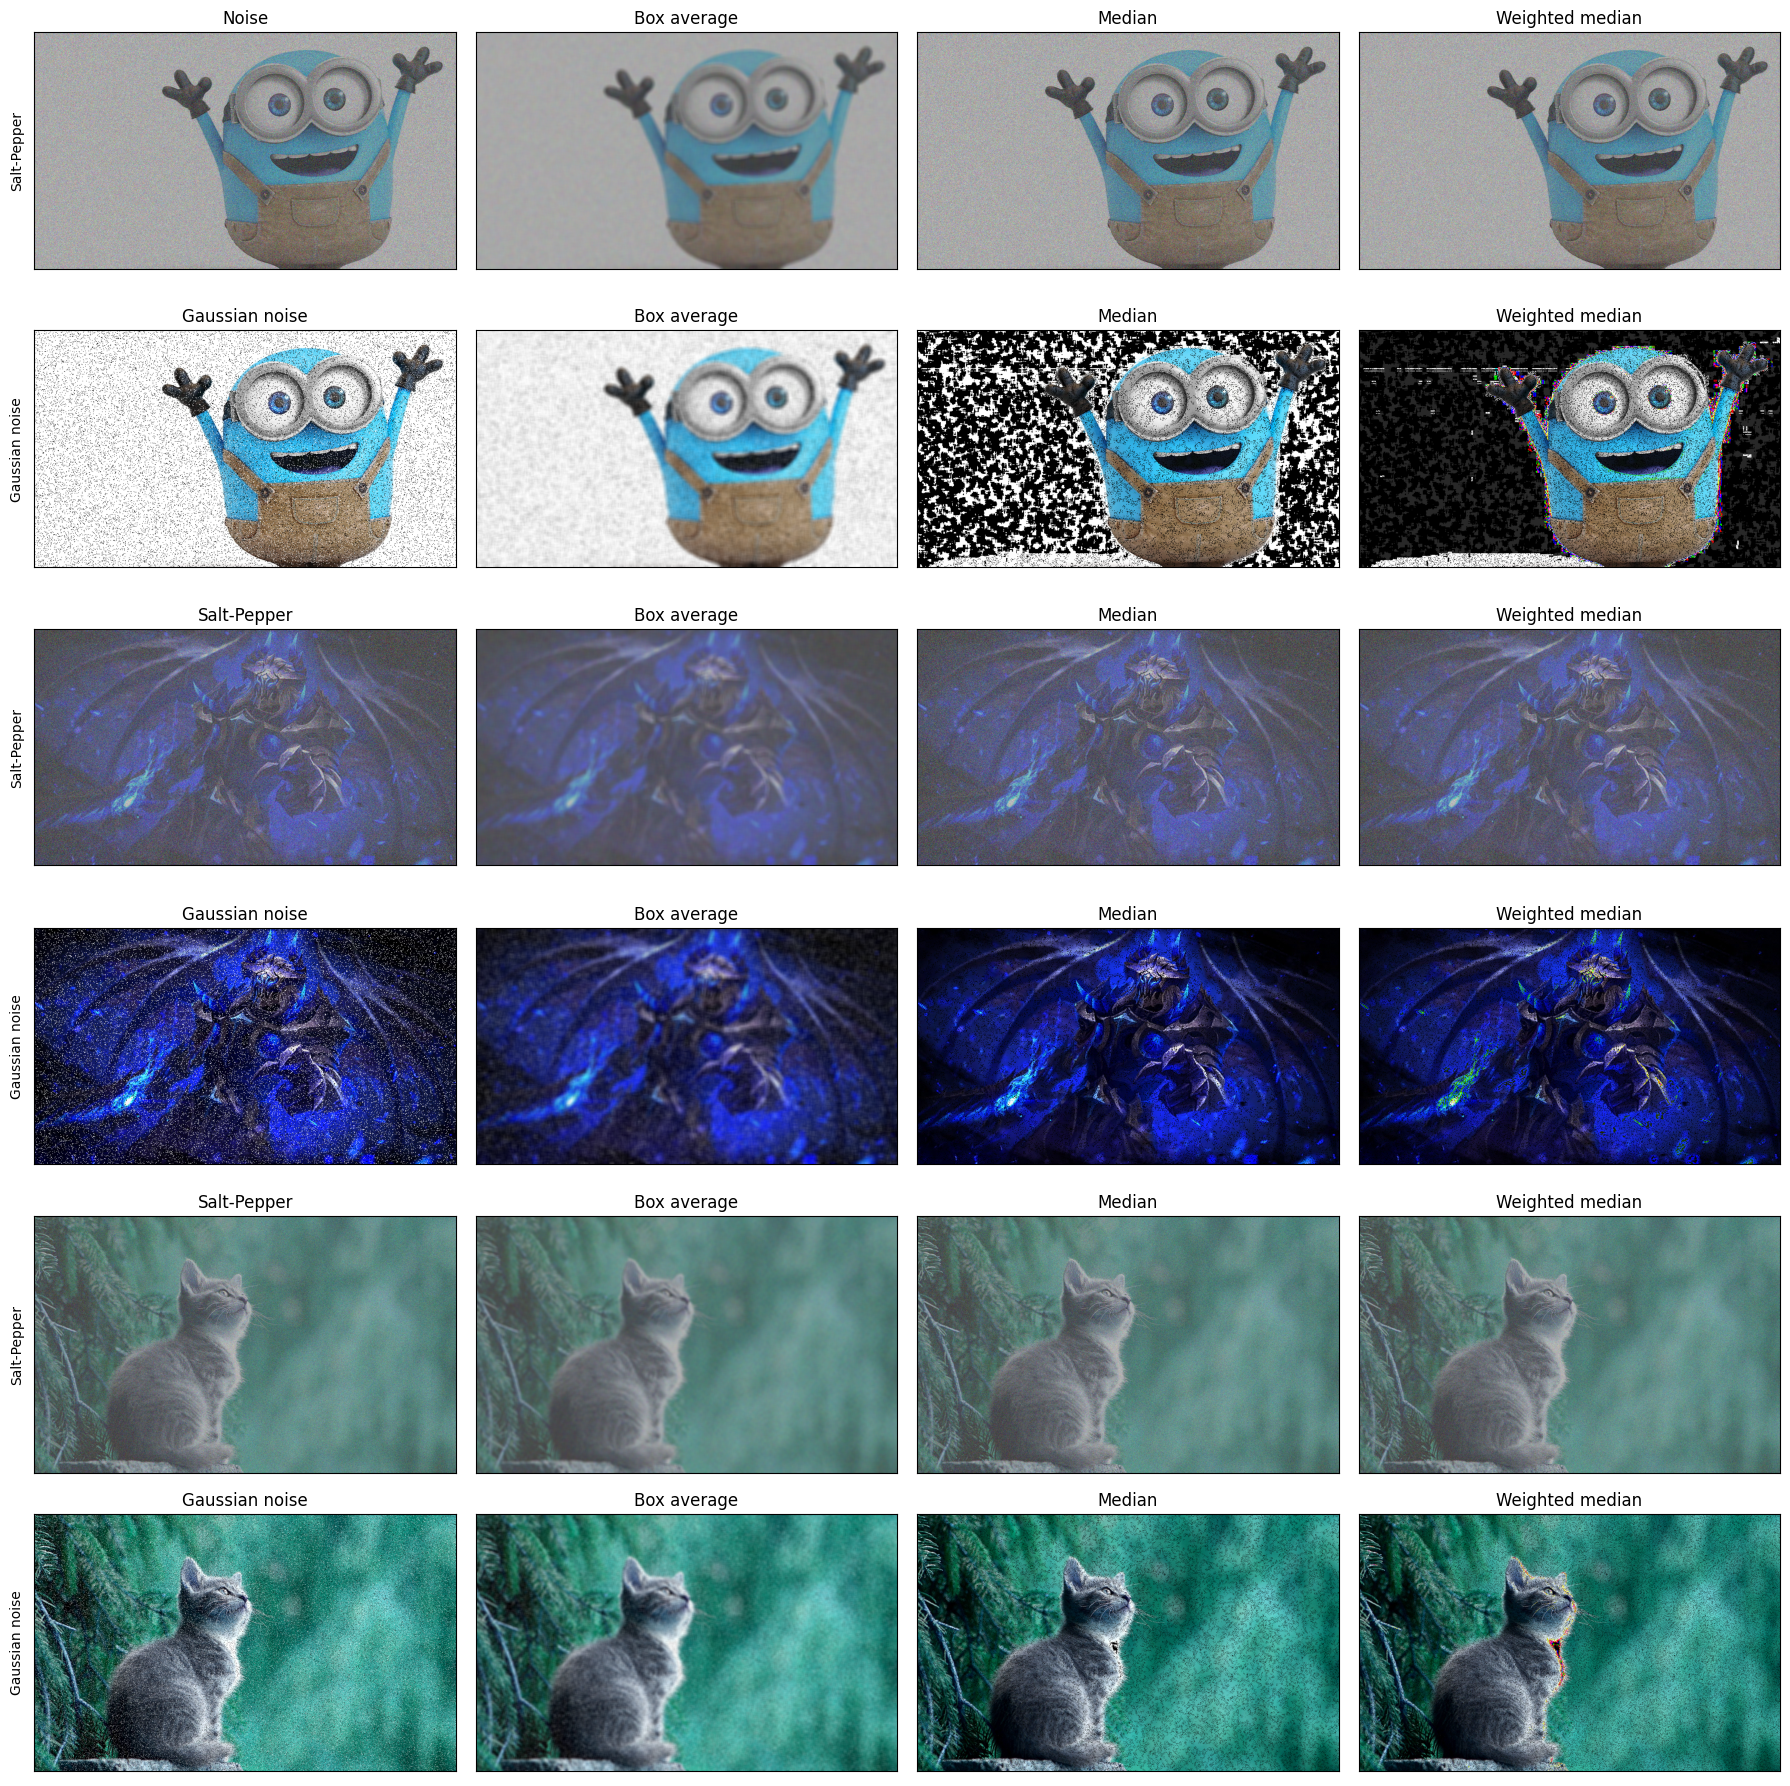

In [74]:
def plot_image(ax, img, title):
    ax.imshow(img)
    ax.xaxis.set_major_locator(ticker.NullLocator())
    ax.yaxis.set_major_locator(ticker.NullLocator())
    ax.set_title(title)

def process_and_plot_images(image_pairs, noise_function, title_prefix, axes, row_index):
    for i, (img_name, img) in enumerate(image_pairs.items()):
        n, sp = save_noised_img(img, img_name)
        plot_image(axes[row_index + i * 2, 0], n, "Salt-Pepper")
        plot_image(axes[row_index + i * 2 + 1, 0], sp,"Gaussian noise")
        plot_image(axes[row_index + i * 2, 1], noise_function(n, 9), "Box average")
        plot_image(axes[row_index + i * 2 + 1, 1], noise_function(sp, 9), "Box average")
        plot_image(axes[row_index + i * 2, 2], median(n, 9), "Median")
        plot_image(axes[row_index + i * 2 + 1, 2], median(sp, 9), "Median")
        plot_image(axes[row_index + i * 2, 3], wieghted_median(n, 9), "Weighted median")
        plot_image(axes[row_index + i * 2 + 1, 3], wieghted_median(sp, 9), "Weighted median")

def set_labels_and_titles(axes):
    for i in range(0, 6, 2):
        axes[i, 0].set_ylabel("Salt-Pepper")
        axes[i + 1, 0].set_ylabel("Gaussian noise")

    axes[0, 0].set_title("Noise")
    axes[0, 1].set_title("Box average")
    axes[0, 2].set_title("Median")
    axes[0, 3].set_title("Weighted median")

rows, cols = 6, 4
fig, axes = plt.subplots(rows, cols, figsize=(18, 18))

image_pairs = {
    "minion": minion,
    "dota": dota,
    "cat": cat
}

process_and_plot_images(image_pairs, box_average, "Box average", axes, 0)
set_labels_and_titles(axes)

plt.tight_layout()
plt.show()


**Висновок**: фото фарбуються у зелений/синій. Перевіримо HSV 

In [76]:
hsv_minion = cv.cvtColor(minion, cv.COLOR_BGR2HSV)
hsv_dota = cv.cvtColor(dota, cv.COLOR_BGR2HSV)
hsv_cat = cv.cvtColor(cat, cv.COLOR_BGR2HSV)

def hsv_wieghted_median(img: np.ndarray, kernel_size: int) -> np.ndarray:
    pading_value = int(kernel_size/2)
    pading_img = pad_img(img, pading_value)

    result_img = np.copy(img)
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            kernel = gs_kernel(kernel_size)
            window_kernel = np.sort(np.multiply(pading_img[x : x + kernel_size, y : y + kernel_size, 0], kernel).reshape(np.power(kernel_size, 2)))
            result_img[x, y][0] = window_kernel[int(kernel_size/2)]


    return result_img.astype('uint8')

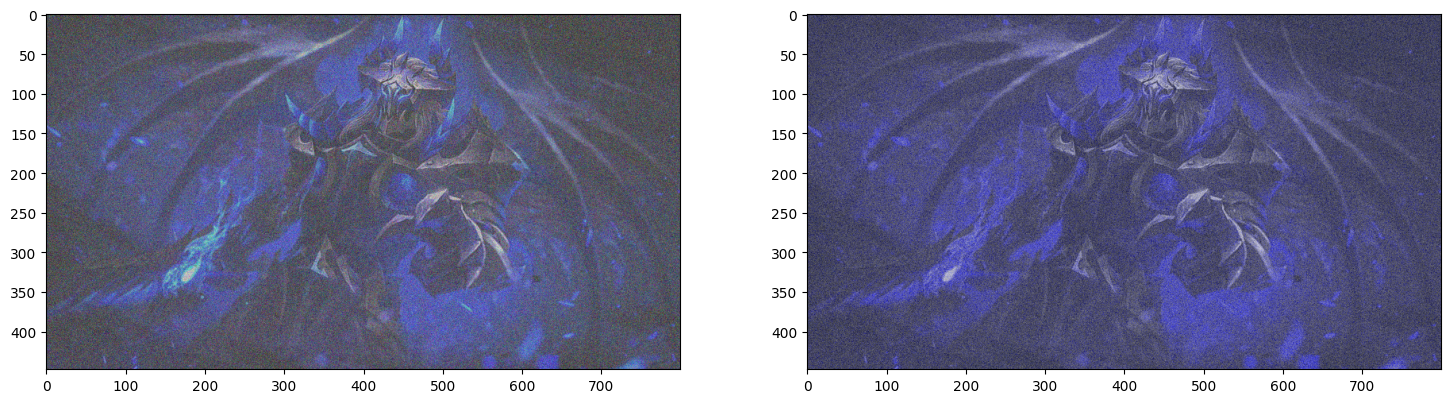

In [77]:
n, sp = save_noised_img(dota, "dota")
n = cv.cvtColor(n, cv.COLOR_BGR2HSV)
sp = cv.cvtColor(sp, cv.COLOR_BGR2HSV)

fig, axes = plt.subplots(1, 2, figsize=(18, 18))

axes[0].imshow(cv.cvtColor(n, cv.COLOR_HSV2BGR))
axes[1].imshow(cv.cvtColor(hsv_wieghted_median(n, 9), cv.COLOR_HSV2BGR))